## Scope

The purpose of this notebook is to present the final models used in my thesis in order to reconstruct a pixelated image. For each model, it is shown a plot with the pixelated image, the target image and the result of the model. At the end, there are 2 plots shown with the respective Mean Squared Error for each model.

### Necessary Imports

In [1]:
import numpy as np
from PIL import Image
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch.nn as nn
import torch

### Loading the image

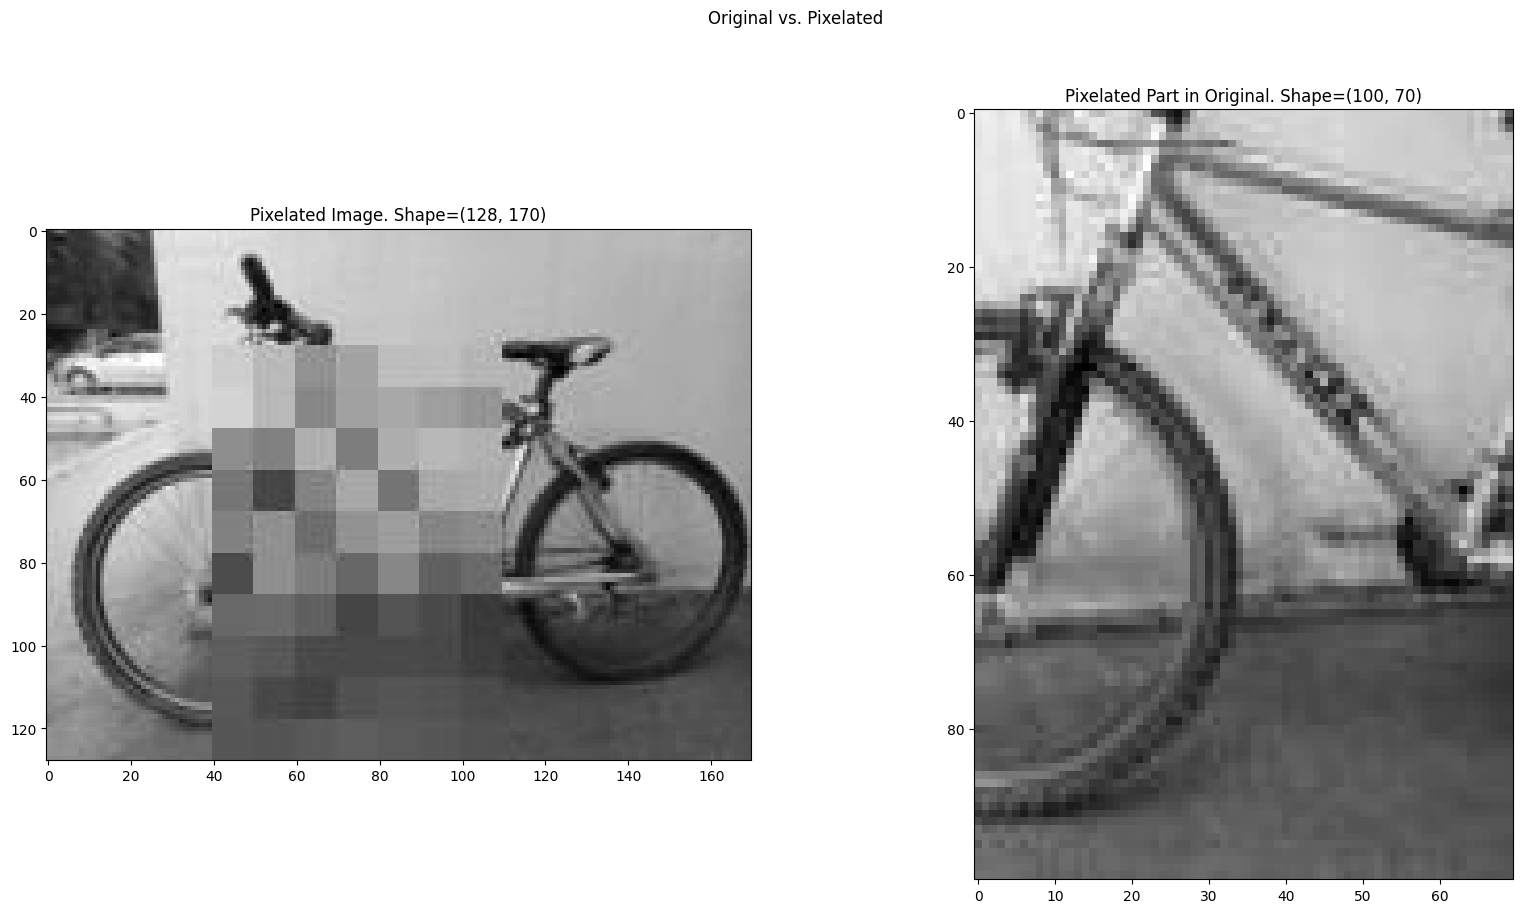

In [2]:
IMAGE_PATH = './small_pix_image3.jpg'
PICKLE_FILE = './small_pix_known_array3.pkl'
TARGET_PATH = './small_pix_target3.jpg'

grayscale_img = np.asarray(Image.open(IMAGE_PATH))
target_array = np.asarray(Image.open(TARGET_PATH))

fig, axs = plt.subplots(1, 2, figsize=[20, 10])
axs[0].imshow(grayscale_img, cmap='gray')
axs[0].set_title(f"Pixelated Image. Shape={grayscale_img.shape}")
axs[1].imshow(target_array, cmap='gray')
axs[1].set_title(f"Pixelated Part in Original. Shape={target_array.shape}")

plt.suptitle('Original vs. Pixelated')
plt.show()

known_array = pickle.load(open(PICKLE_FILE, 'rb'))
known_array = known_array.reshape(known_array.shape[1],known_array.shape[2])
grayscale_img = grayscale_img.reshape(grayscale_img.shape[0],grayscale_img.shape[1],1)
grayscale_img = grayscale_img.mean(axis=2)

Train method for the regression models

In [3]:
def plotting_method(image, target_array, final_image, flag=False):
  fig, axs = plt.subplots(1, 3, figsize=[21, 12])

  axs[0].imshow(image, cmap='gray')
  axs[0].set_title('Pixelated Image')

  axs[1].imshow(target_array, cmap='gray')
  axs[1].set_title('Target Part')

  axs[2].imshow(final_image, cmap='gray')
  axs[2].set_title('Model Result')

  if not flag:
    fig.suptitle("Pixelated vs. Original vs. Model (output using the boolean mask)")
  else:
    fig.suptitle("Pixelated vs. Original vs. Model (whole output from model)")
  plt.show()

In [4]:
def find_model_output(regressor, known_array, image, target_array, train_size=0.02):
    height, width = image.shape
    flat_image = image.reshape(-1)
    xs = np.arange(len(flat_image)) % width
    ys = np.arange(len(flat_image)) // width
    data = np.array([xs, ys]).T
    target = flat_image
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=train_size, random_state=42)
    mean = trainY.mean()
    regressor.fit(trainX, trainY - mean)
    flat_picture = regressor.predict(data) + mean

    final_image = np.copy(image)

    flat_picture = flat_picture.reshape(image.shape[0],image.shape[1])

    final_image[known_array==0] = flat_picture[known_array==0]

    target_flat_metrics = target_array.copy().flatten()
    model_result_flat_metric = flat_picture[known_array==0].copy().flatten()

    mse = mean_squared_error(target_flat_metrics,model_result_flat_metric)

    plotting_method(image, target_array, final_image)

    return mse

In [5]:
final_knn20neighbors = 0
final_knn25neighbors = 0
final_randomforest = 0
final_decisiontressdepth40leaf7 = 0
final_adaboost01 = 0
final_cnn = 0

### CNN architecture

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.list_instructions = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.list_instructions(x)
        return x

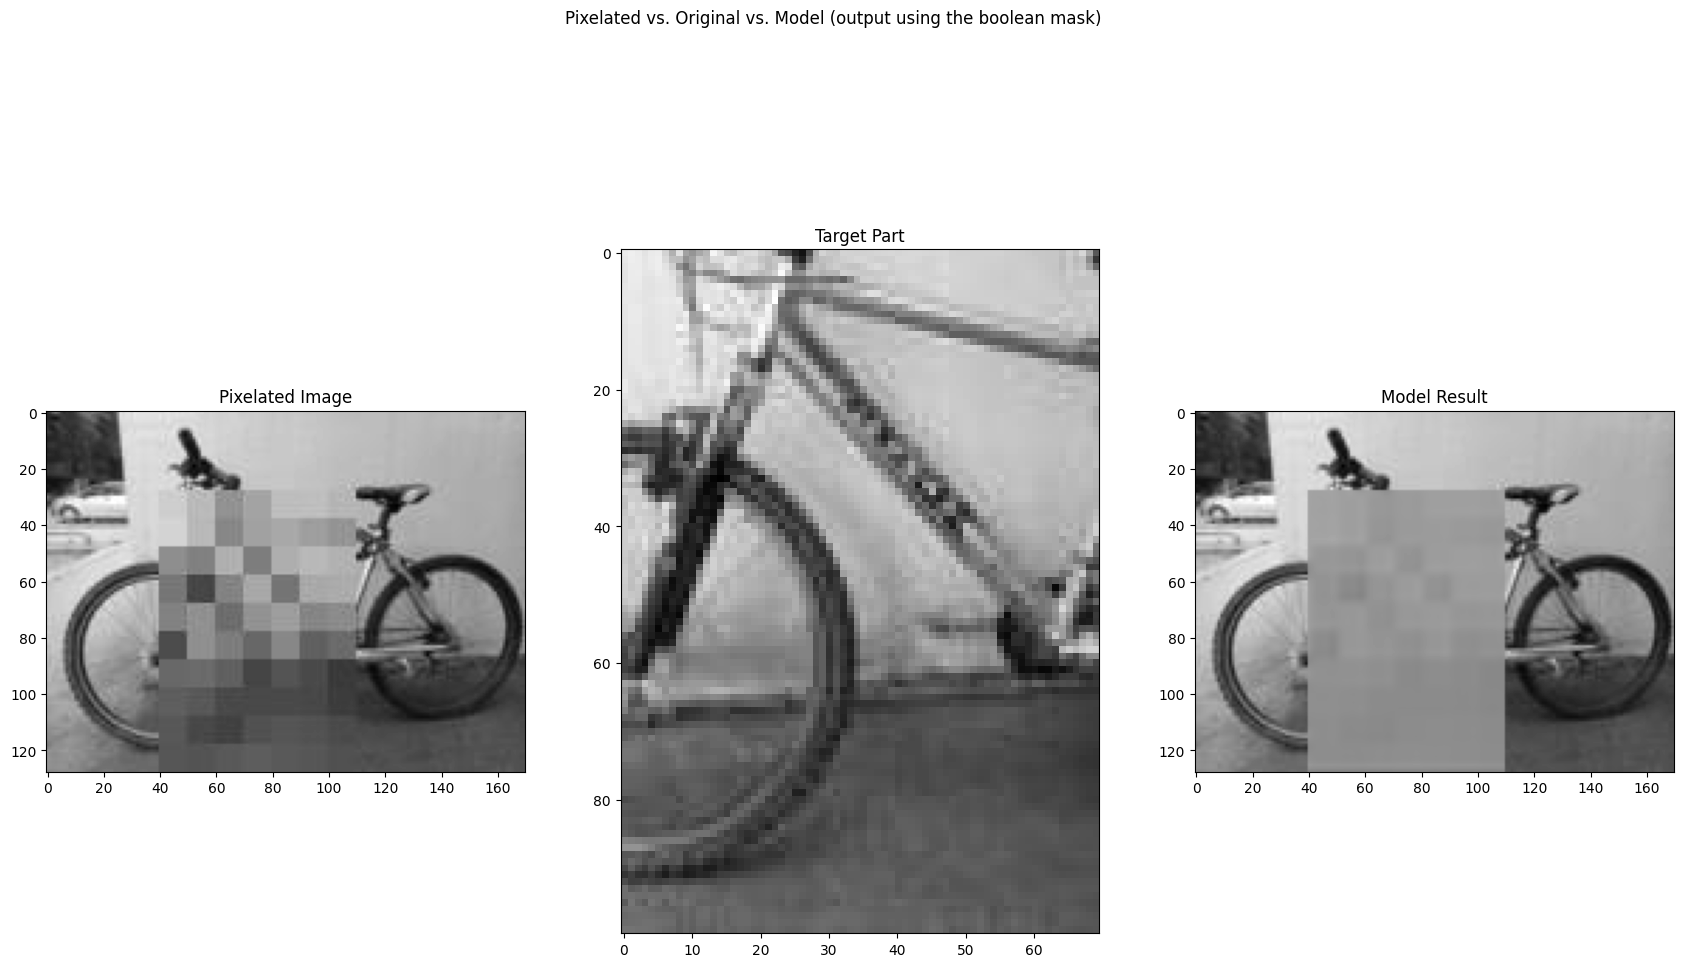

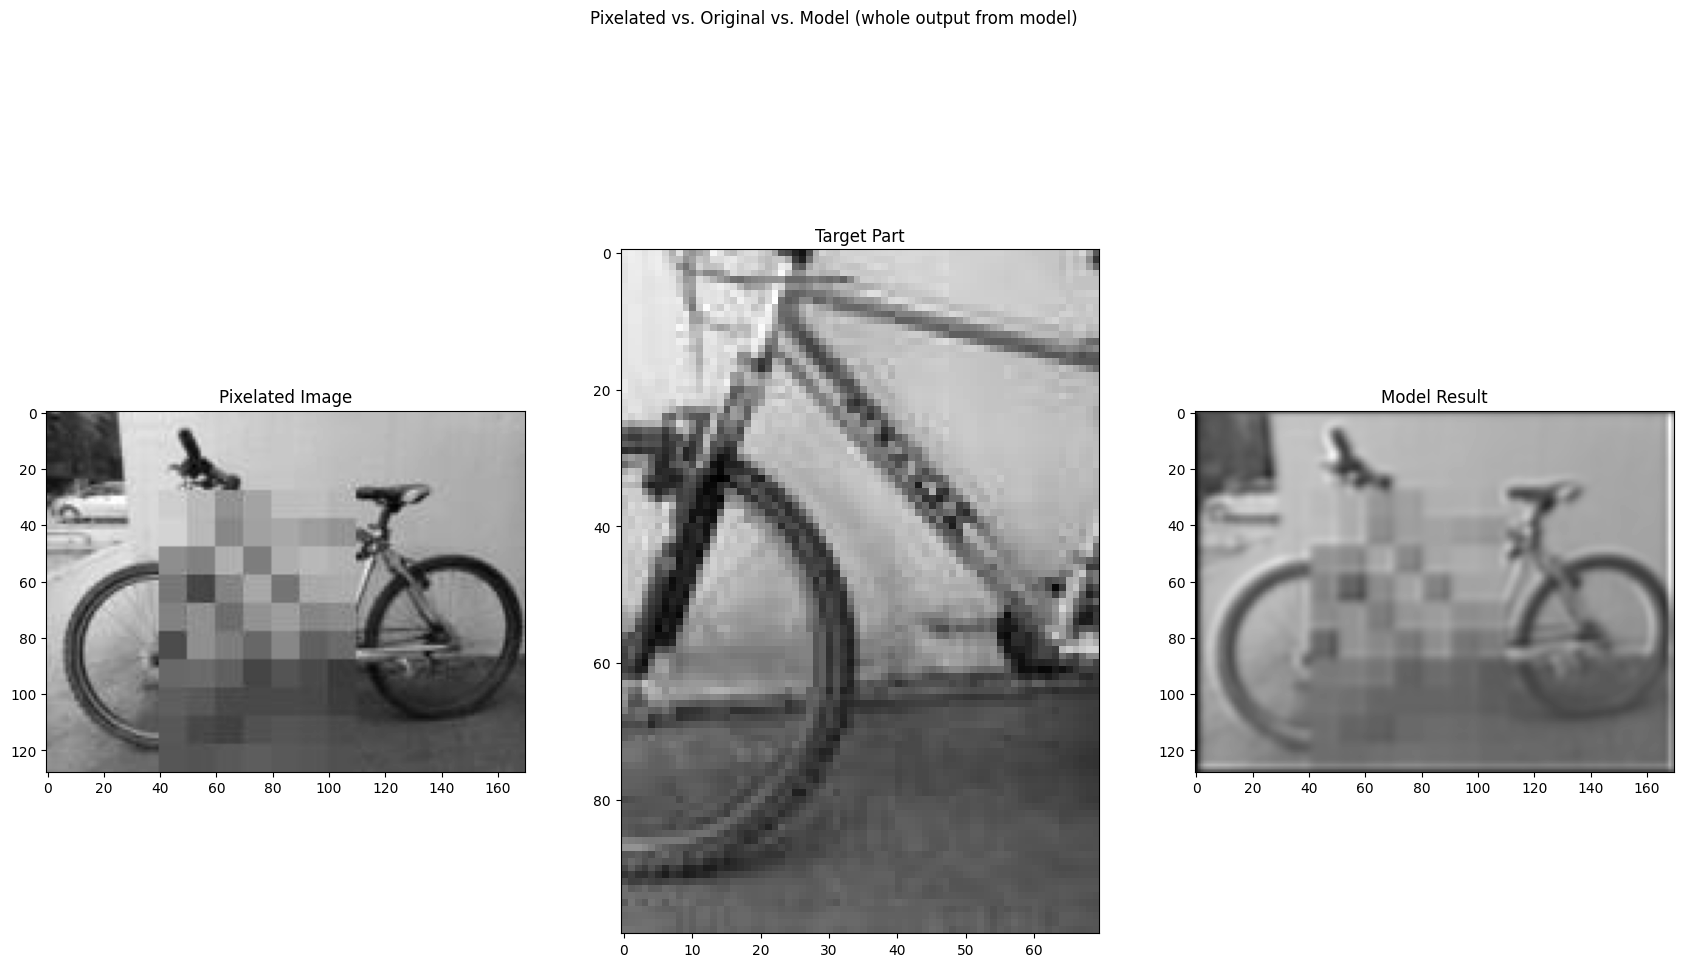

In [7]:
model = CNNModel()
model.load_state_dict(torch.load("CNNModel.pth"))
model.eval()
grayscale_img_tensor=torch.tensor(grayscale_img.copy(), dtype=torch.float32).unsqueeze(0)
grayscale_img_tensor=torch.div(grayscale_img_tensor,255.0)

with torch.no_grad():
    output = model(grayscale_img_tensor)

grayscale_img_tensor=grayscale_img_tensor.squeeze(0)
output = output.squeeze(0)

grayscale_img_tensor = torch.mul(grayscale_img_tensor, 255.0)
output = torch.mul(output,255.0)

output = output.cpu().detach().numpy()
grayscale_img_tensor = grayscale_img_tensor.cpu().detach().numpy()

grayscale_img_tensor[known_array==0]=output[known_array==0]

final_cnn = mean_squared_error(target_array.flatten(),output[known_array==0])

grayscale_img_tensor=grayscale_img_tensor.reshape(grayscale_img.shape[0],grayscale_img.shape[1])
known_array = known_array.reshape(grayscale_img.shape[0],grayscale_img.shape[1])
output = output.reshape(grayscale_img.shape[0],grayscale_img.shape[1])

plotting_method(grayscale_img, target_array, grayscale_img_tensor)
plotting_method(image = grayscale_img, target_array = target_array, final_image = output, flag=True)

### K-Nearest Neigbours
- 20 neighbours
- with `canberra` metric

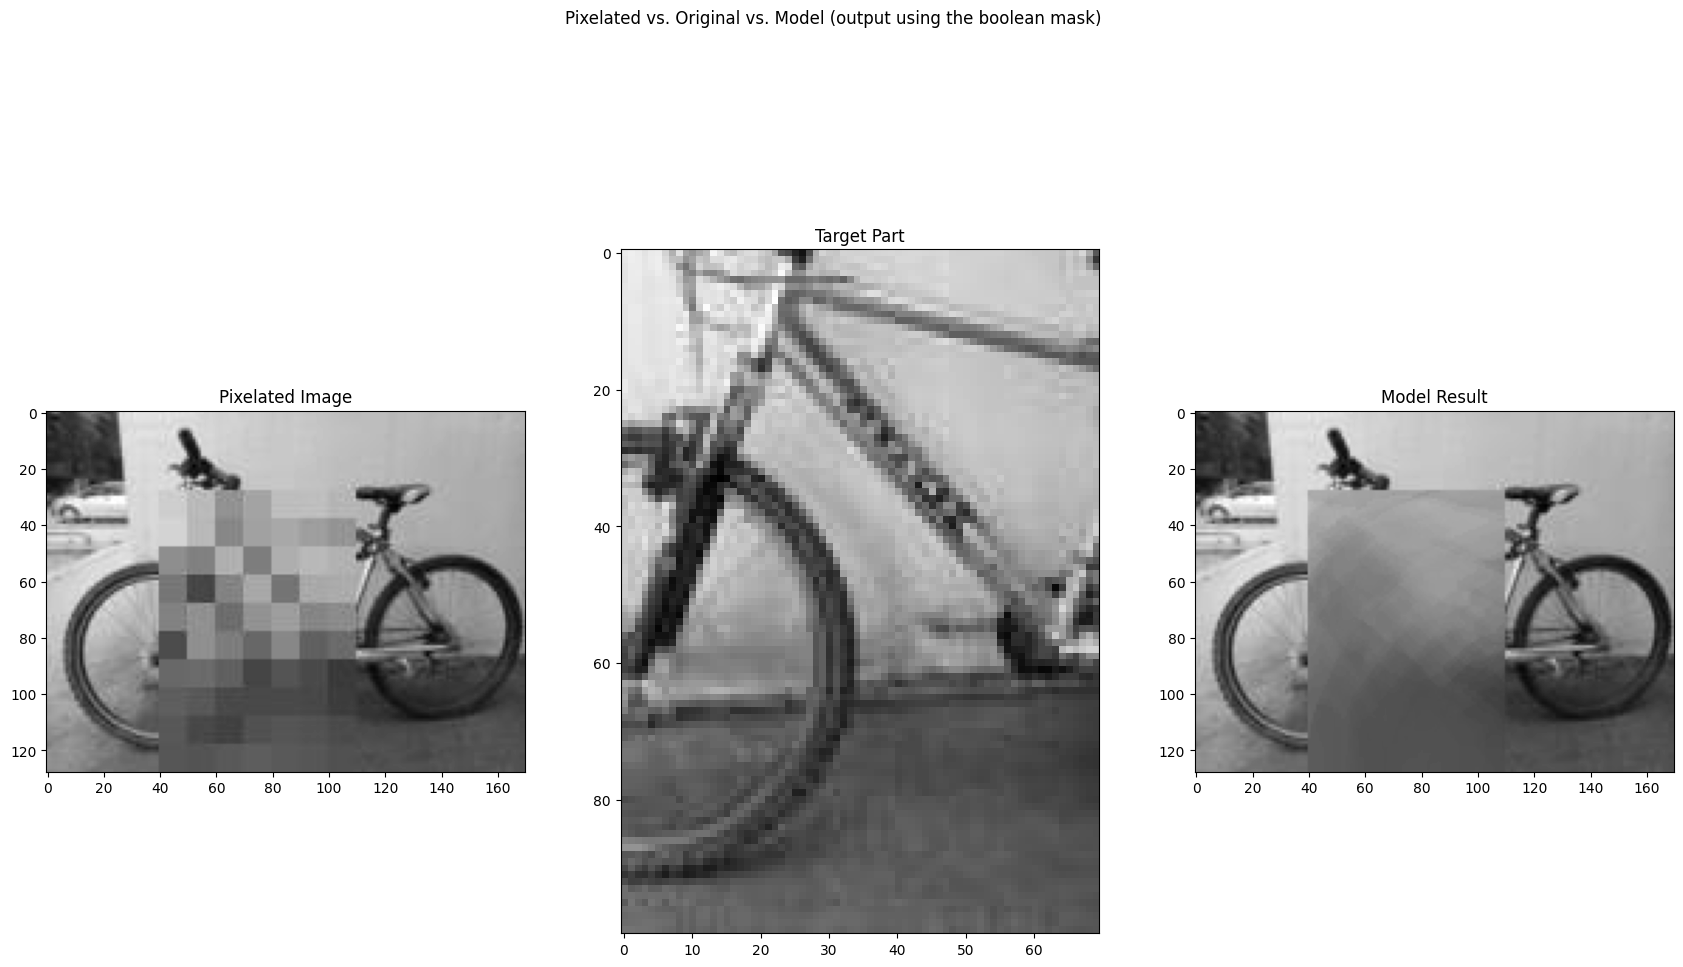

In [8]:
final_knn20neighbors = find_model_output(
  regressor=KNeighborsRegressor(n_neighbors=20, metric='canberra'),
  known_array = known_array,
  image = grayscale_img,
  target_array = target_array
)

### K-Nearest Neigbours
- 25 neighbours
- wieghts = `distance`

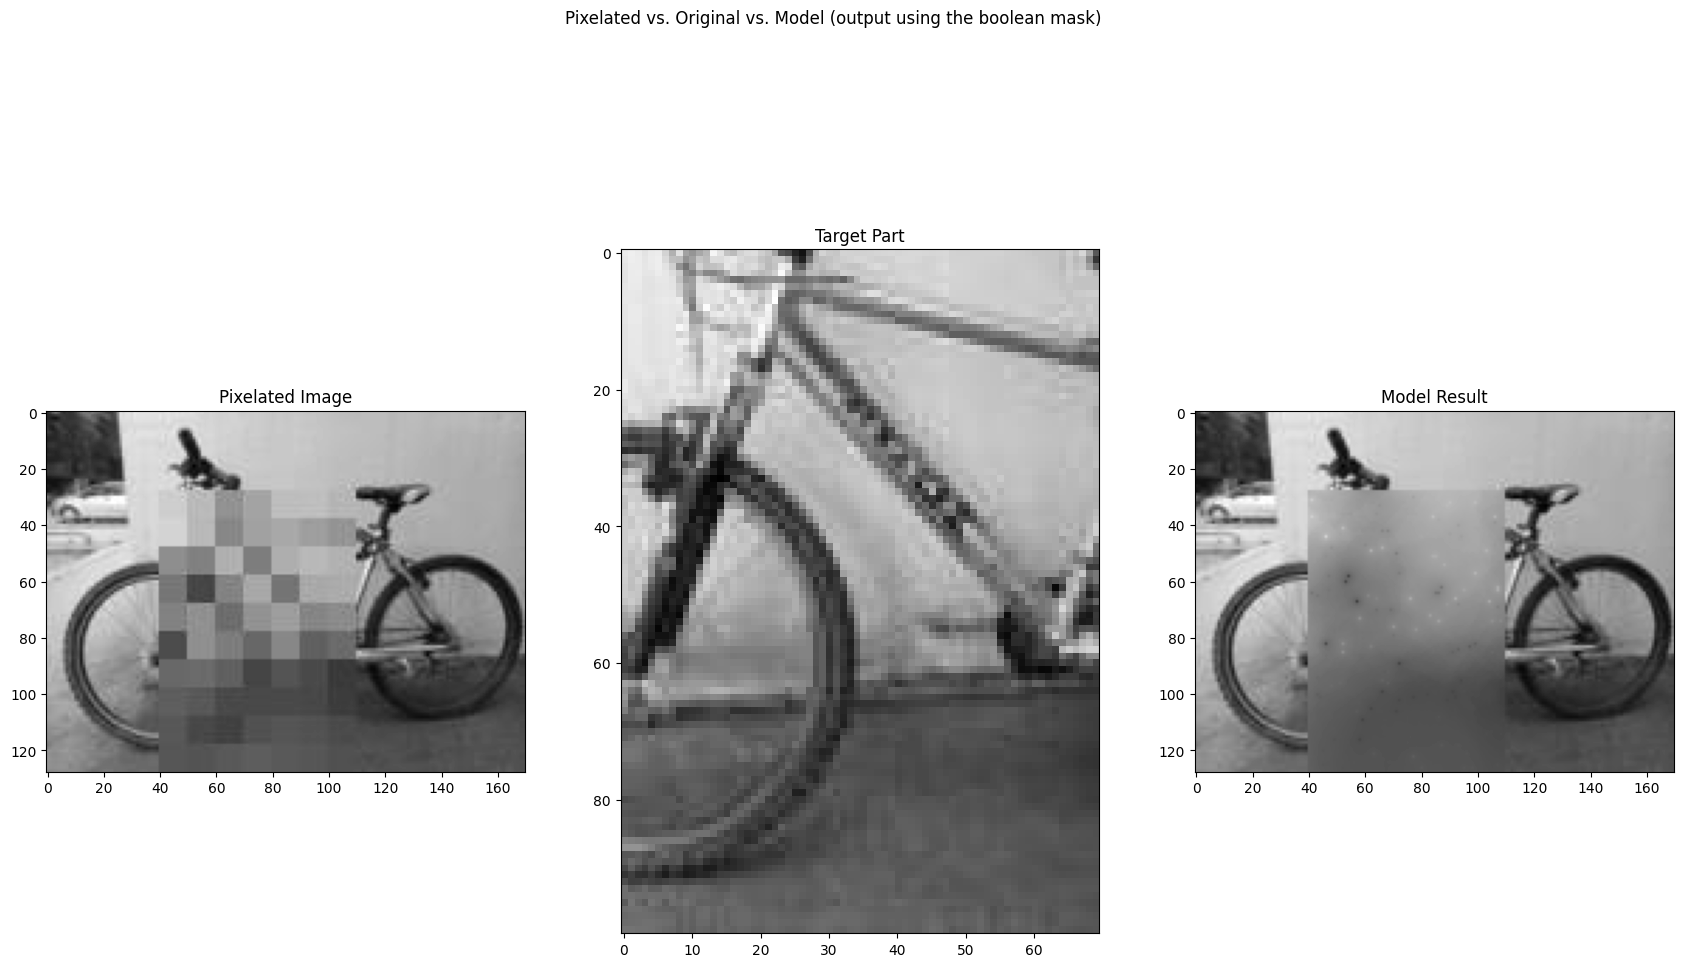

In [9]:
final_knn25neighbors = find_model_output(
    regressor=KNeighborsRegressor(n_neighbors=25, weights='distance'),
    known_array=known_array,
    image=grayscale_img,
    target_array = target_array
)

### Random Forest
- 100 estimators

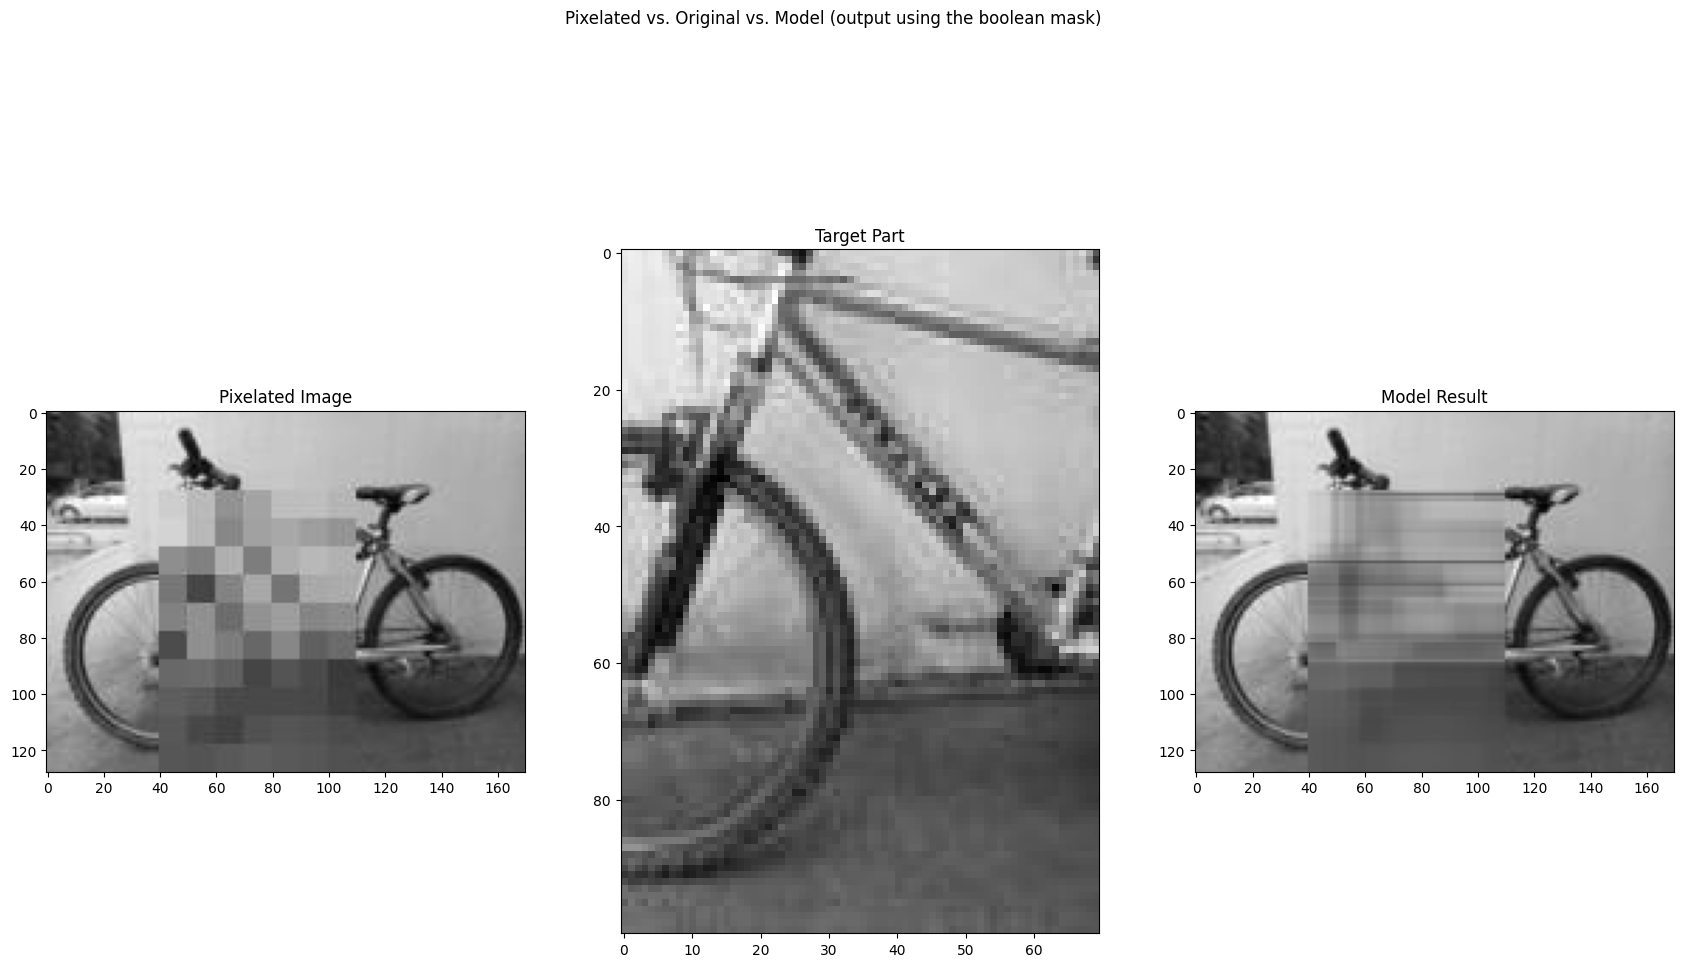

In [10]:
final_randomforest = find_model_output(
    regressor=RandomForestRegressor(n_estimators=100),
    known_array=known_array,
    image=grayscale_img,
    target_array=target_array
)

### Decision Trees
- 40 max depth
- 7 for minimum number of samples in leaf

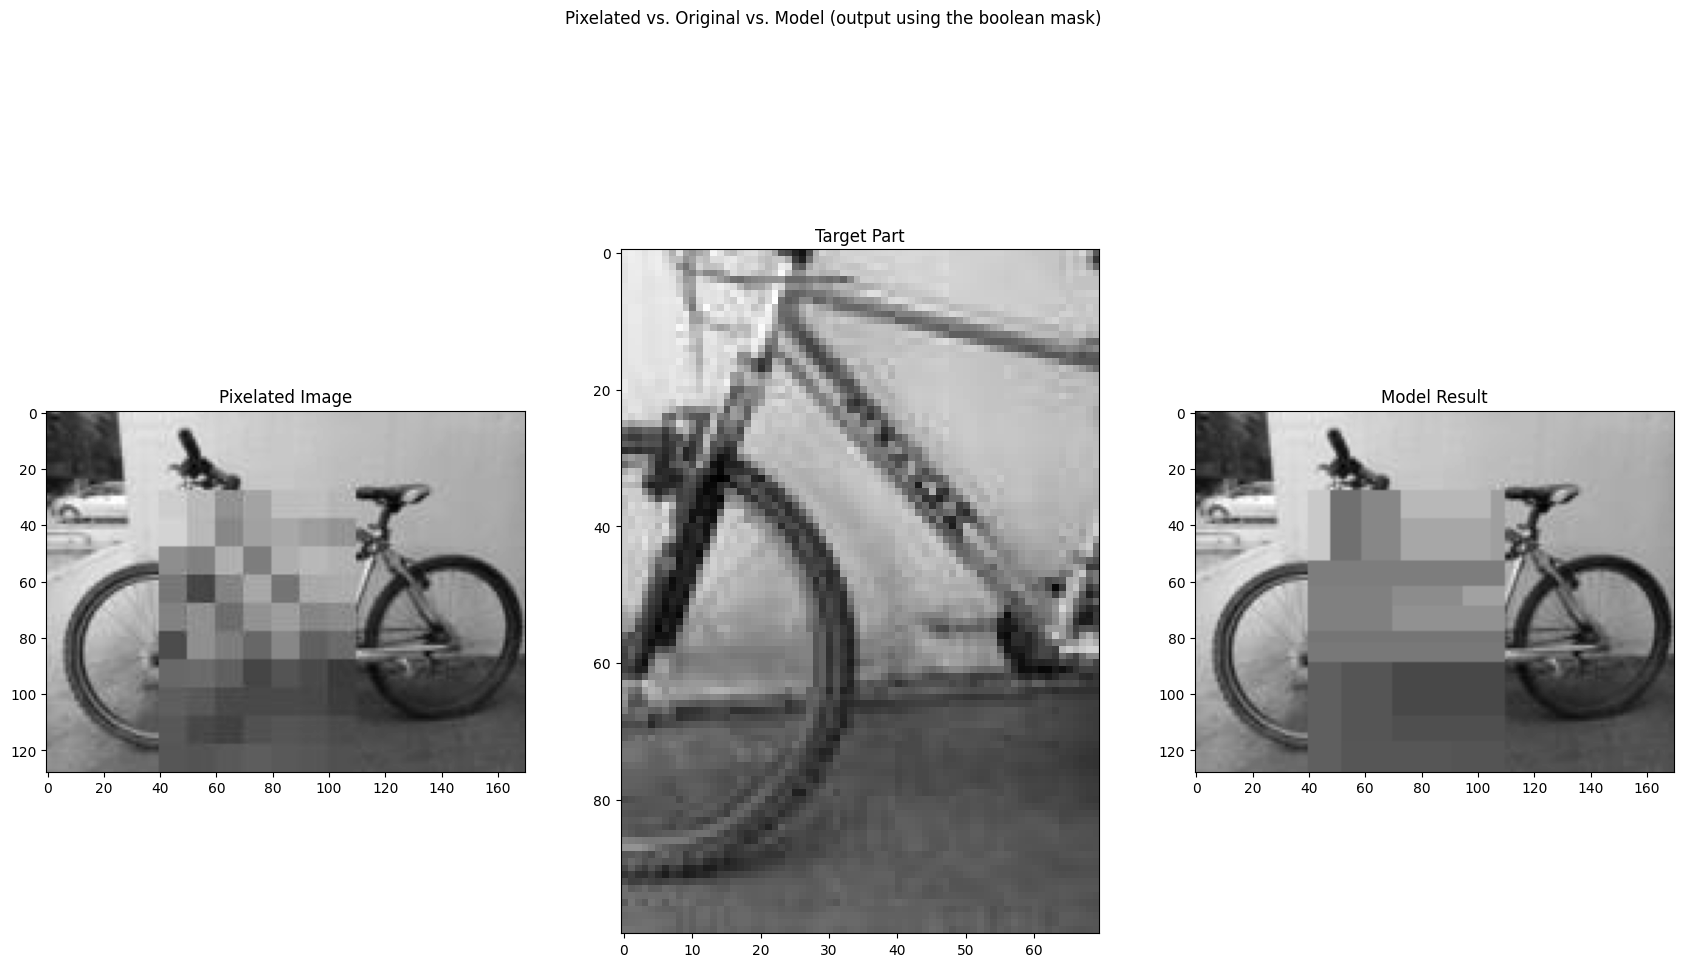

In [11]:
final_decisiontressdepth40leaf7 = find_model_output(
    regressor=DecisionTreeRegressor(max_depth=40,min_samples_leaf=7),
    known_array=known_array,
    image=grayscale_img,
    target_array=target_array
)

### AdaBoost
- 50 estimators
- 0.01 learning rate

/usr/local/lib/python3.10/dist-packages/sklearn/random_projection.py:398: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/random_projection.py:398: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/random_projection.py:398: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/random_projection.py:398: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_comp

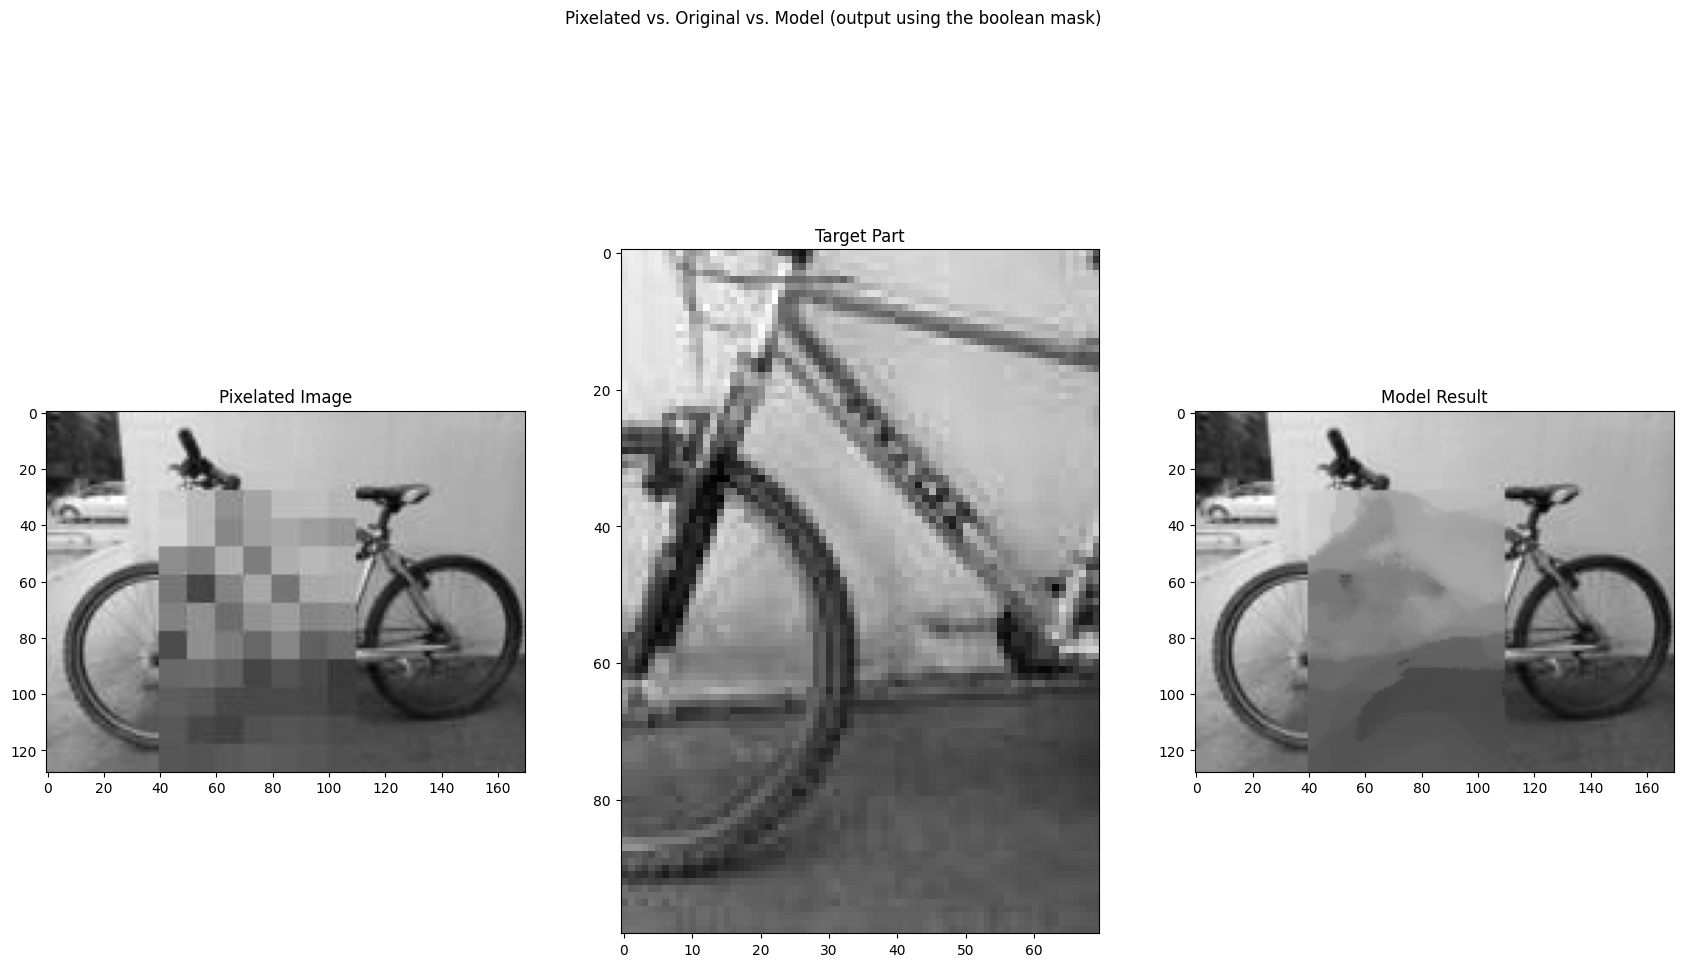

In [12]:
base = make_pipeline(GaussianRandomProjection(n_components=10),DecisionTreeRegressor(max_depth=10, max_features=5))
final_adaboost01 = find_model_output(
    regressor=AdaBoostRegressor(base, n_estimators=50, learning_rate=0.01),
    known_array=known_array,
    image=grayscale_img,
    target_array=target_array
)

## Plotting the MSE Losses for all the models from above

### Vertical Bar Plot

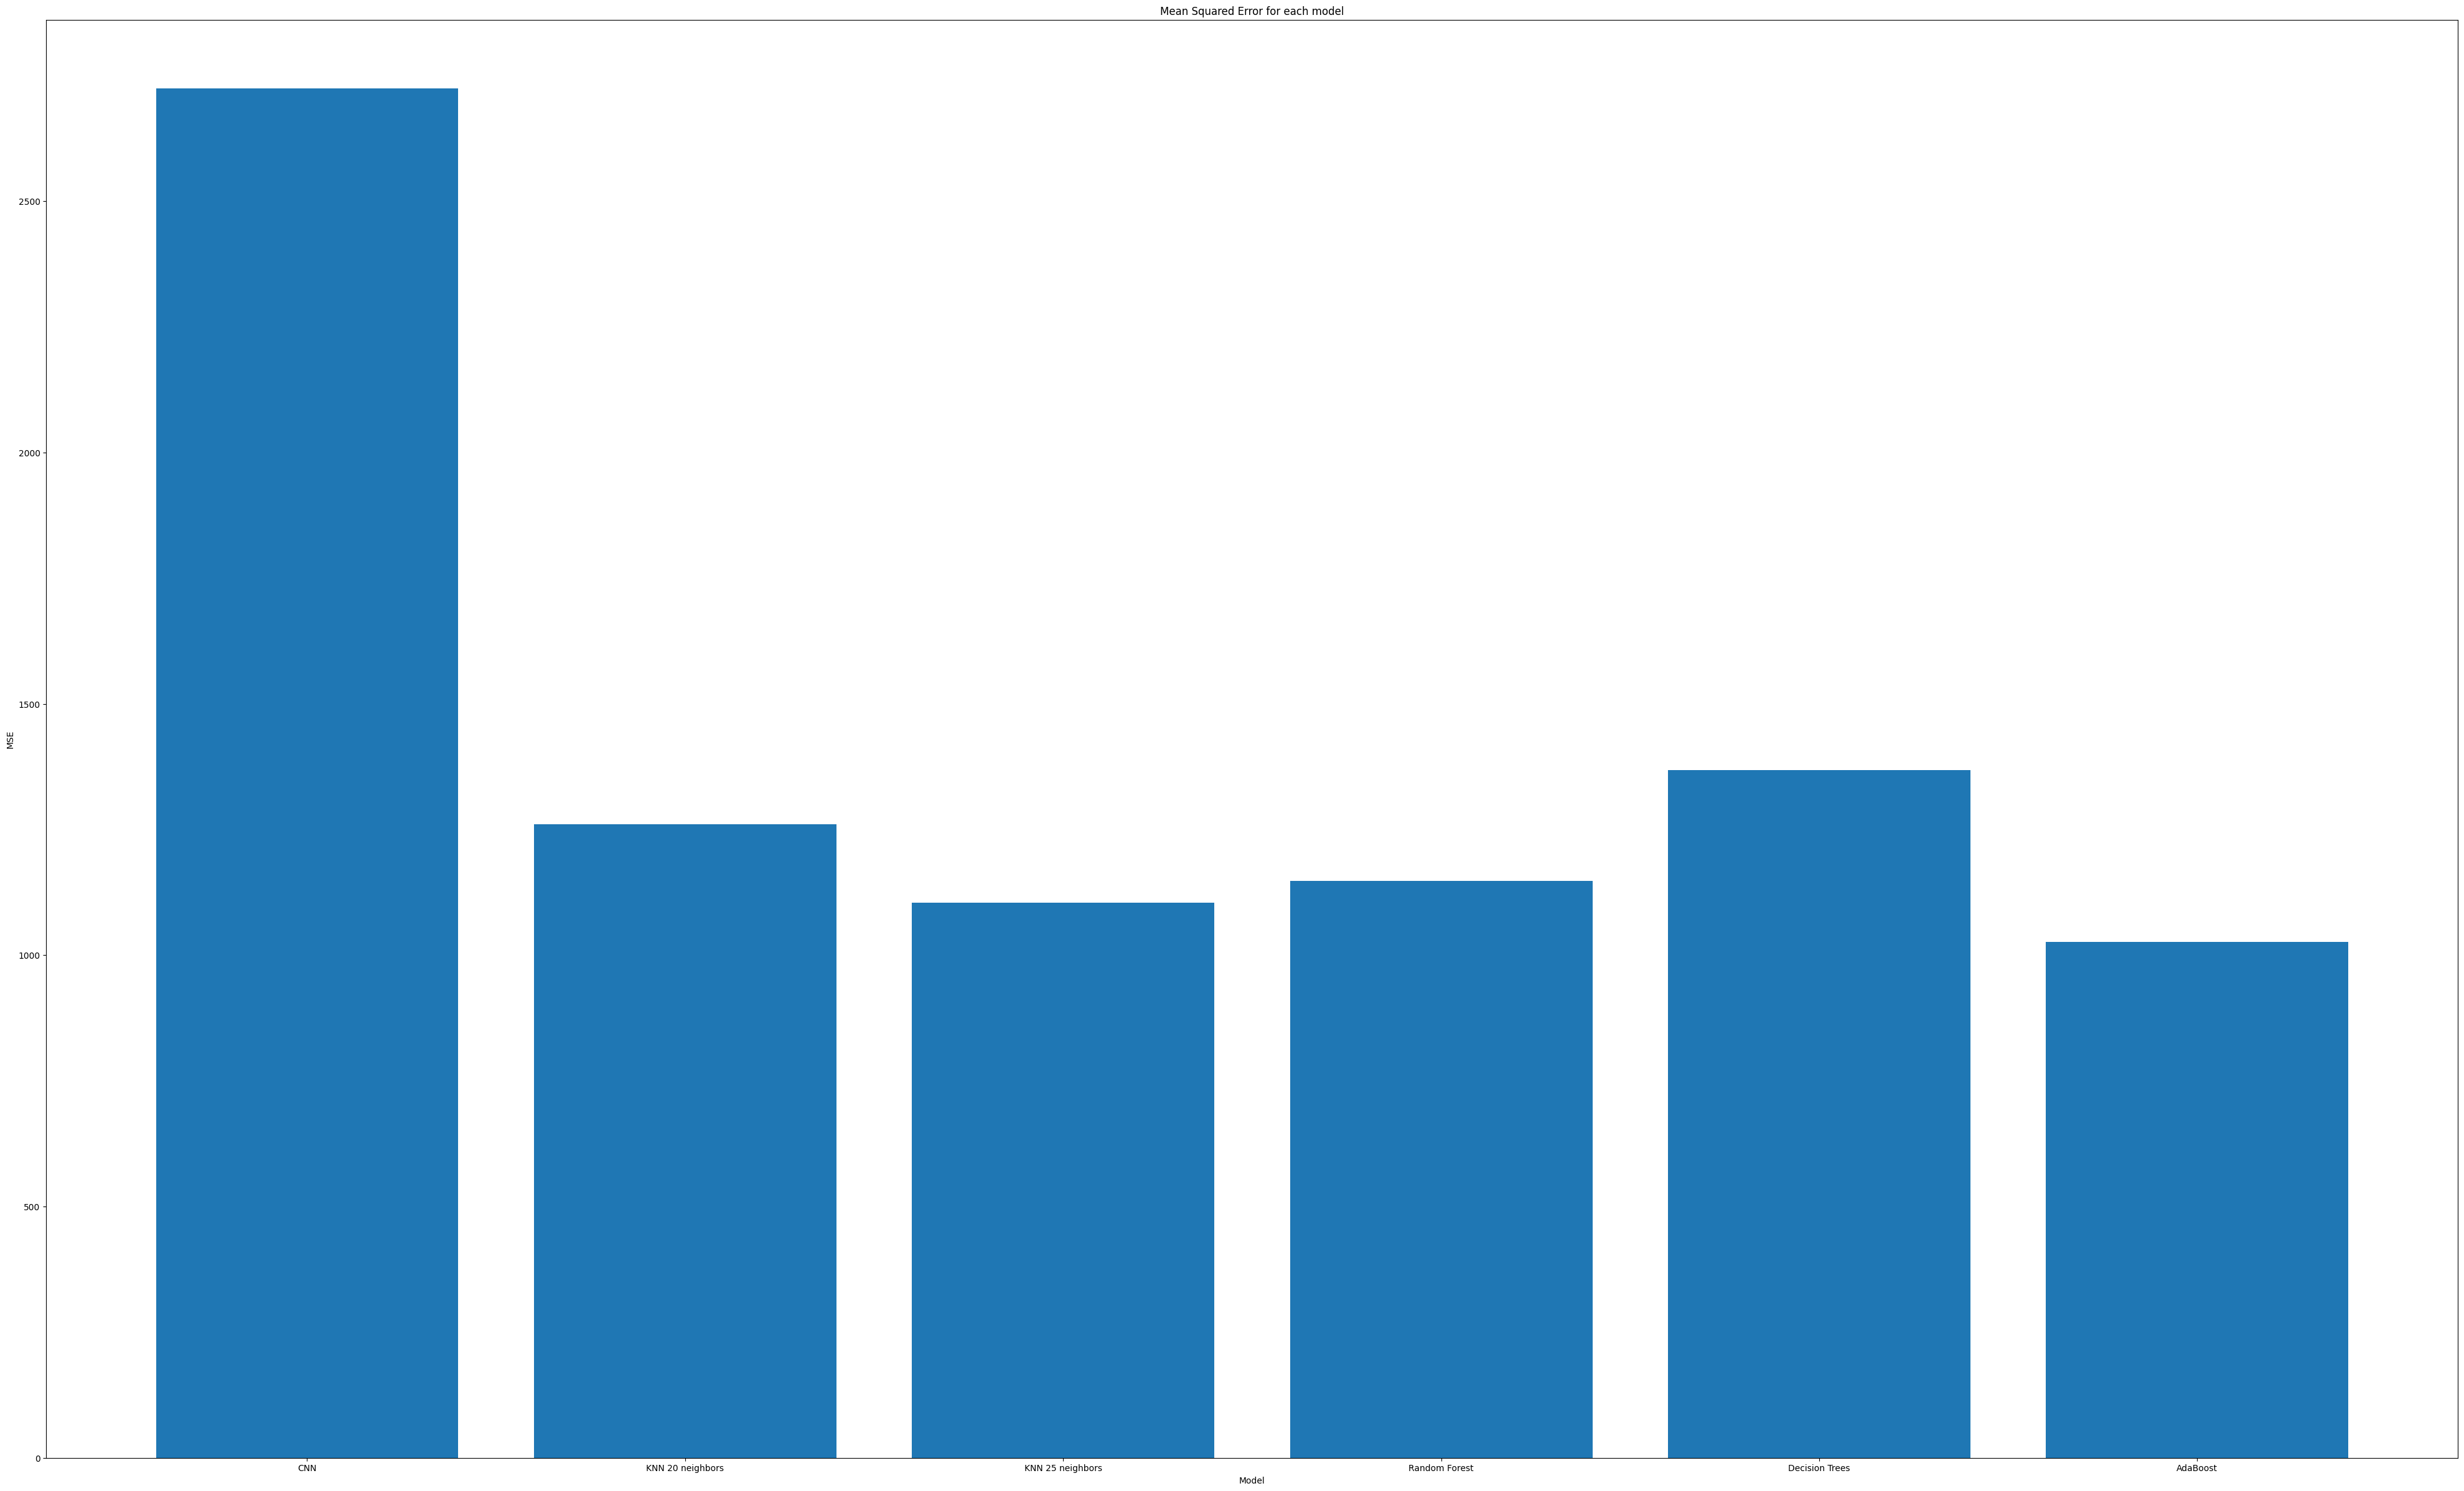

In [13]:
data = {
    "CNN": final_cnn,
    "KNN 20 neighbors": final_knn20neighbors,
    "KNN 25 neighbors": final_knn25neighbors,
    "Random Forest": final_randomforest,
    "Decision Trees": final_decisiontressdepth40leaf7,
    "AdaBoost": final_adaboost01
}

model_names = list(data.keys())
loss_values = list(data.values())

fig = plt.figure(figsize = (50, 30))

plt.bar(model_names, loss_values)

plt.xlabel("Model")
plt.ylabel("MSE")
plt.title("Mean Squared Error for each model")
plt.show()

### Horizontal Bar Plot

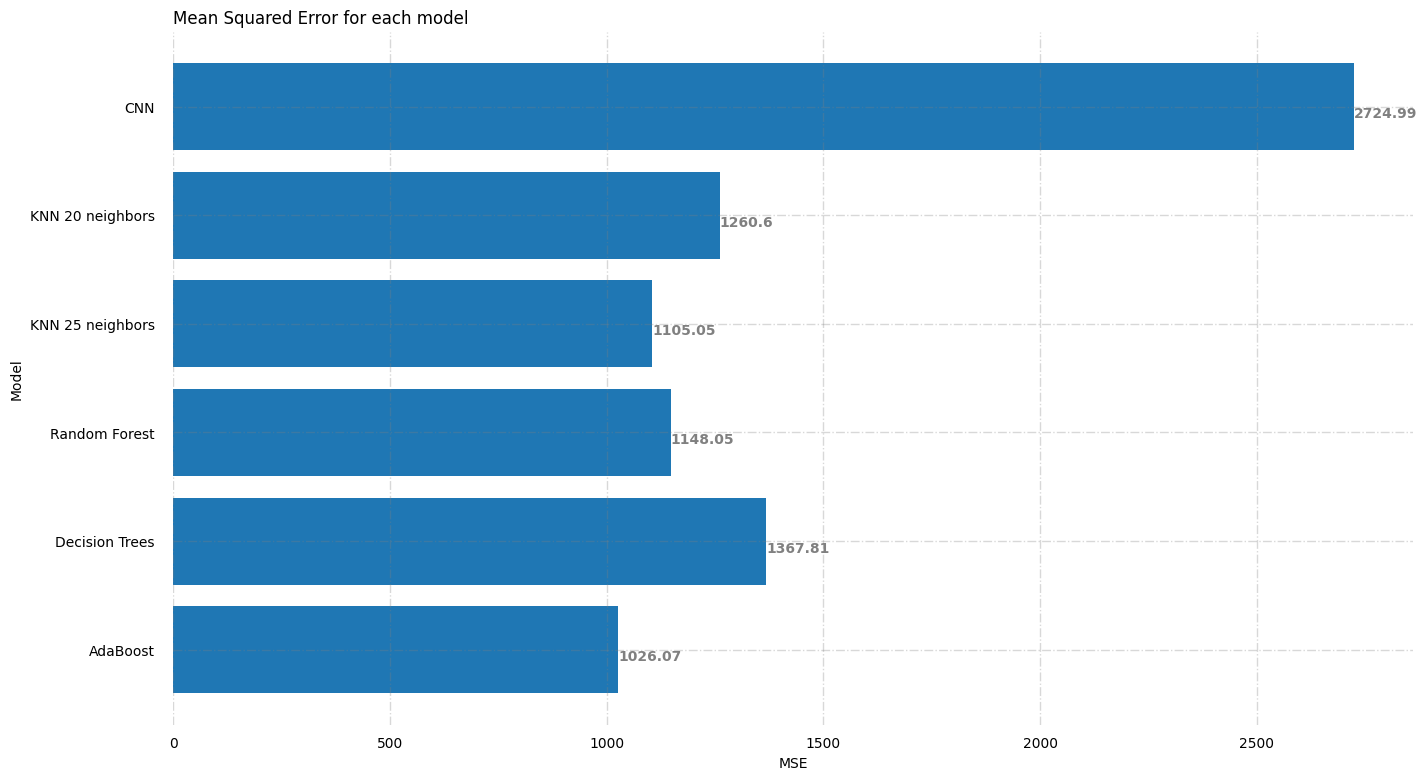

In [14]:
model = []
loss = []

for key, value in data.items():
    model.append(key)
    loss.append(value)

result = {"model": model, "loss": loss}

df = pd.DataFrame(result)

name = df['model'].head(12)
price = df['loss'].head(12)

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(name, price)

for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(color ='grey',linestyle ='-.', linewidth = 1.0, alpha = 0.3)

ax.invert_yaxis()

for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)),fontsize = 10, fontweight ='bold',color ='grey')

# Add Plot Title
ax.set_title('Mean Squared Error for each model',loc='left')
ax.set_xlabel("MSE")
ax.set_ylabel("Model")

plt.show()